# Proposta Técnica: Inteligência de Sinais em Séries Temporais Financeiras

**@Autor** 
    Vasco Edgar Gomes Loureiro

**@Data** 14 / 01 / 2025

## Visão Geral - Executive Summary**

Este projeto propõe o desenvolvimento de uma pipeline de Machine Learning end-to-end para a extração de tendências estruturais em ativos do S&P 500. A abordagem diferencia-se ao tratar o preço não como uma variável isolada, mas como um sinal composto por uma componente de tendência (drift) e uma componente de ruído (estocástica/sentimento).

---

> Nota Académica: Este projeto é uma Prova de Conceito (PoC). Embora utilize técnicas de vanguarda em MLOps, o seu objetivo é a análise estatística de tendências e não a garantia de retornos financeiros. O risco e a incerteza são componentes integrais do modelo.

In [ ]:
!pip install -q yfinance
!pip install -q mlxtend
!pip install -q catboost
!pip install -q xgboost
!pip install -q lightgbm

In [20]:
from datetime import datetime, timedelta
from scipy.stats import linregress

import os
import json
import pandas as pd
import numpy as np
# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações dos estilos dos graficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

# Fonte dos dados api yahoo finance
import yfinance as yf

# ML
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score, 
                             classification_report, confusion_matrix, roc_auc_score)

#Exportar Ml
import joblib
from pykalman import KalmanFilter

import warnings
warnings.filterwarnings('ignore')

## Criação do Dataset

### Extração dos Dados

Extraimos os dados via API do yahoo finance, definindo 3 ações de estudo. O Intervalo de tempo dos valores das ações foi definido com base nos ciclos econômicos, uma vez que estes ciclos possuem uma duração de ~5 anos foi eleito este periodo de tempo, posteriomente, precisamos 4 dias para um lookback histórico para calcular as inferencias. 

In [3]:
# Tickers das Ações Tecnológicas da S&P 500 
tickers = [
    'AAPL', 
    'MSFT', 
    'GOOGL'
]
  
end = datetime.now()
start = end - timedelta(days = 5 * 365 + 4) 

dfs={}

In [5]:
for stock in tickers:
    try:
        print(f"  Downloading {stock}...", end=" ")
        df = yf.download(stock, start=start, end=end, progress=False)
        if len(df) > 0:
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = df.columns.get_level_values(0)
            df = df.reset_index()
            df['Ticker'] = stock
            dfs[stock] = df
            print(f"{len(df)} dias")
        else:
            print("Sem dados !")
    except Exception as e:
        print(f"Erro: {e}")

df_raw = pd.concat(dfs.values(), axis=0, ignore_index=True)
print(f"\nTotal: {len(df_raw)} registros")
print(f"\nPeríodo: {df_raw['Date'].min().date()} até {df_raw['Date'].max().date()}\n")


Total: 3774 registros

Período: 2021-01-12 até 2026-01-14



In [6]:
df_raw.head()

Price,Date,Close,High,Low,Open,Volume,Ticker
0,2021-01-12,125.380669,126.247041,123.492169,125.088630,91951100,AAPL
1,2021-01-13,127.415161,127.960292,125.078882,125.341703,88636800,AAPL
2,2021-01-14,125.487755,127.522267,125.341728,127.327579,90221800,AAPL
3,2021-01-15,123.764725,126.762960,123.628442,125.361186,111598500,AAPL
4,2021-01-19,124.436409,125.293052,123.570037,124.387733,90757300,AAPL


#### Visualização dos Dados Retirados

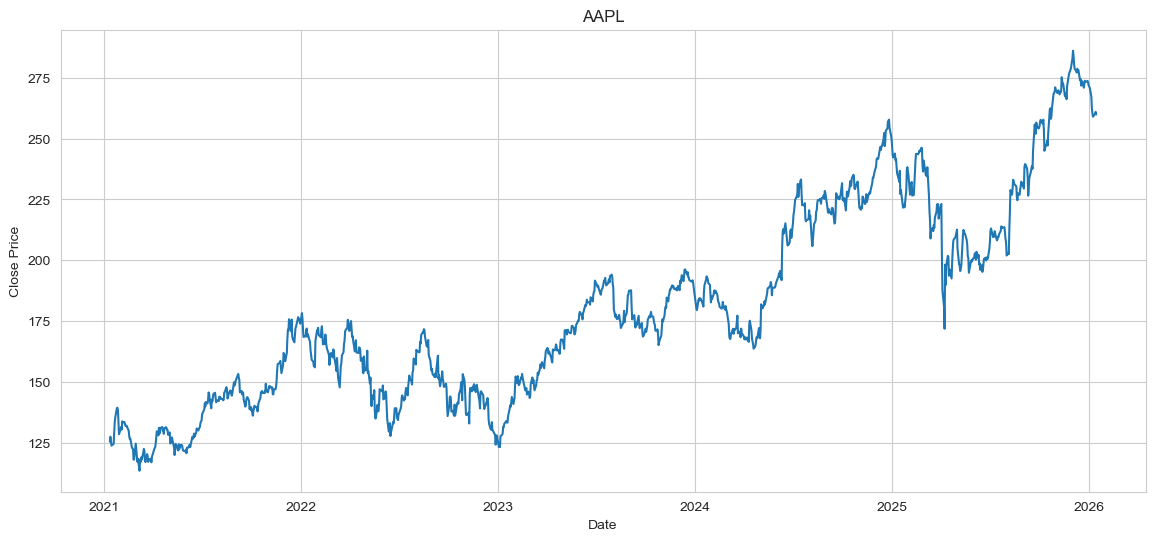

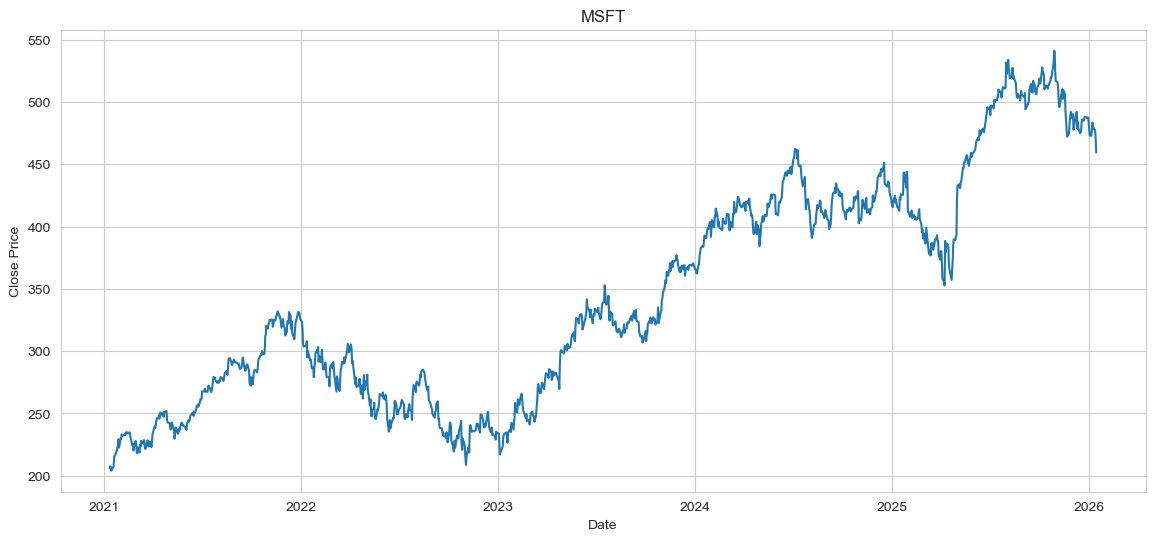

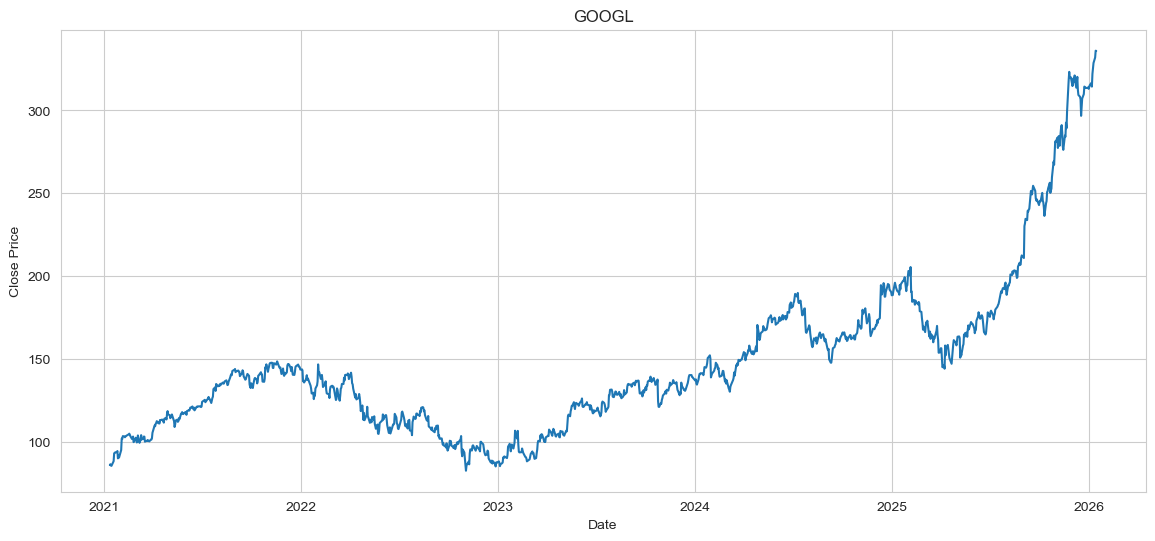

In [9]:
for stock in df_raw['Ticker'].unique():
    data = df_raw[df_raw['Ticker'] == stock]
    
    plt.plot(data['Date'], data['Close'])
    plt.title(stock)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

## Feature Engeneering

Criamos features que irão ajudar o modelo a fazer decisões mais acertivas conforme os dados presentes no `dataframe`

### Decomposição: Tendência e Ruido

Decompõe o preço em tendência (média móvel) e ruído (desvio da tendência). **Conceito** : `Preço = Tendência + Ruído`

O sinal e o ruido disponíveis para a decisão de hoje baseiam-se apenas no que aconteceu até ontem 

Usamos o `Metodo Kalma Filter`, um algoritmo para estimar o estado de um sistema dinamico.

In [11]:
def apply_kalma_filter(series, process_variance=0.01, observation_variance=1.0):
    kf = KalmanFilter(
        transition_matrices=[1],                            # F: Estado não muda estruturalmente
        observation_matrices=[1],                           # H: Observamos o estado diretamente
        transition_covariance = [[process_variance]],       # Q: Variância do processo
        observation_covariance= [[observation_variance]],   # R: Variância da observação
        initial_state_mean=series.iloc[0],
        initial_state_covariance=1
    )
    
    state_means, _ = kf.filter(series.values)
    trend = state_means.flatten()
    noise = series.values - trend
    return trend, noise

### Classifica a tendência baseada em múltiplos indicadores:
- Inclinação da tendência (slope)
- Força da tendência (R²)
- Magnitude da mudança percentual

Retorna;
-1 (Lateral) | 0 ( Baixa) | 1 (Alta)|  


In [13]:
def classify_trend(df, window = 20, threshold_pct = 2.0):
 
    trend_class = []
    
    for idx in range(len(df)):
        if idx < window:
            # Dados insuficientes
            trend_class.append(-1) 
            continue
            
        window_data = df.iloc[idx-window:idx]['Trend'].values
        
        if pd.isna(window_data).any():
            trend_class.append(-1)
            continue
            
        # Regressão linear
        x = np.arange(len(window_data))
        slope, intercept, r_value, p_value, std_err = linregress(x, window_data)
        
        # Mudança percentual
        pct_change = ((window_data[-1] - window_data[0]) / window_data[0]) * 100
        
        # R² - Força da tendência 
        r_squared = r_value ** 2
        
        # Classificação multi-critério
        if r_squared < 0.65:  
            # Tendência fraca/inconsistente
            trend_class.append(-1)
        elif slope > 0 and pct_change > threshold_pct:
            trend_class.append(1)       
        elif slope < 0 and pct_change < -threshold_pct:
            trend_class.append(0)
        else:
            trend_class.append(-1)
    return trend_class

###  Elaboração de Indicadores Técnicos

Criamos todos os indicadores tecnicos que posteriormente iram ser usados como features

In [15]:
def create_technical_indicators(df):
    df = df.copy()
    
    # Retornos
    df['Return_1d'] = df.groupby('Ticker')['Close'].pct_change(1)
    df['Return_5d'] = df.groupby('Ticker')['Close'].pct_change(5)
    df['Return_10d'] = df.groupby('Ticker')['Close'].pct_change(10)
    
    # Médias Móveis
    df['SMA_5'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(5).mean())
    df['SMA_10'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(10).mean())
    df['SMA_20'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).mean())
    df['SMA_50'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(50).mean())
    
    # Cruzamento de médias
    df['SMA_Cross_5_20'] = (df['SMA_5'] - df['SMA_20']) / df['SMA_20']
    df['SMA_Cross_10_50'] = (df['SMA_10'] - df['SMA_50']) / df['SMA_50']
    
    # RSI
    def calculate_rsi(prices, period=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    df['RSI_14'] = df.groupby('Ticker')['Close'].transform(lambda x: calculate_rsi(x, 14))
    
    # Bollinger Bands
    df['BB_Middle'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).mean())
    df['BB_Std'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).std())
    df['BB_Upper'] = df['BB_Middle'] + (df['BB_Std'] * 2)
    df['BB_Lower'] = df['BB_Middle'] - (df['BB_Std'] * 2)
    df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
    df['BB_Dist_Upper'] = (df['BB_Upper'] - df['Close']) / df['BB_Middle']
    df['BB_Dist_Lower'] = (df['Close'] - df['BB_Lower']) / df['BB_Middle']
    df['BB_ZScore'] = (df['Close'] - df['BB_Middle']) / df['BB_Std']
    
    # MACD
    df['EMA_12'] = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=12).mean())
    df['EMA_26'] = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=26).mean())
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df.groupby('Ticker')['MACD'].transform(lambda x: x.ewm(span=9).mean())
    df['MACD_Diff'] = df['MACD'] - df['MACD_Signal']
    
    # Volume
    df['Volume_MA'] = df.groupby('Ticker')['Volume'].transform(lambda x: x.rolling(20).mean())
    df['Volume_Ratio'] = df['Volume'] / df['Volume_MA']
    
    # Volatilidade
    df['Volatility_5d'] = df.groupby('Ticker')['Return_1d'].transform(lambda x: x.rolling(5).std())
    df['Volatility_20d'] = df.groupby('Ticker')['Return_1d'].transform(lambda x: x.rolling(20).std())
    
    # Range diário
    df['Daily_Range'] = (df['High'] - df['Low']) / df['Close']
    df['Daily_Range_MA'] = df.groupby('Ticker')['Daily_Range'].transform(lambda x: x.rolling(10).mean())
    
    # Componentes de Decomposição (Kalman Filter)
    df['Trend'] = np.nan
    df['Noise'] = np.nan
    df['Volatility'] = np.nan
    df['SNR'] = np.nan
    
    for stock, group in df.groupby('Ticker'):
        trend, noise = apply_kalma_filter(group['Close'])
        vol = pd.Series(noise, index=group.index).rolling(20).std()
        
        df.loc[group.index, 'Trend'] = trend
        df.loc[group.index, 'Noise'] = noise
        df.loc[group.index, 'Volatility'] = vol
        df.loc[group.index, 'SNR'] = np.abs(trend) / (vol + 1e-8)
    
    # Classificação de Tendência - Corrigido
    trend_classes = []
    for stock, group in df.groupby('Ticker'):
        classes = classify_trend(group)
        trend_classes.extend(classes)
    
    df['Trend_Class'] = trend_classes
    
    return df

### Criação de Targets

Uma vez criadas as features iremos criar as variáveis que queremos prever. Estas variáveis são:

- Direção Binária: Sobe / Desce;  
- Direação Muticlasse: Alta / Baixa / Neutra
- Volatilidade: Se o dia é volátil ou não
- Faixa de Preço: Regressão por intervalos


In [22]:
df_features = create_technical_indicators(df_raw)
print(f"Features criadas: {df_features.shape[1]} colunas")

Features criadas: 41 colunas


In [24]:
df_features['Future_Return'] = df_features.groupby('Ticker')['Close'].pct_change().shift(-1)
df_features['Target_Binary'] = (df_features['Future_Return'] > 0).astype(int)

# Target Multiclasse
threshold = 0.005
df_features['Target_Multiclass'] = pd.cut(
    df_features['Future_Return'],
    bins=[-np.inf, -threshold, threshold, np.inf],
    labels=[0, 1, 2]
).astype(float)

# Target Volatilidade
vol_threshold = df_features['Future_Return'].abs().quantile(0.7)
df_features['Target_Volatility'] = (df_features['Future_Return'].abs() > vol_threshold).astype(int)

# Faixa de Preço
df_features['Future_Price'] = df_features.groupby('Ticker')['Close'].shift(-1)
df_features['Price_Change_Pct'] = ((df_features['Future_Price'] - df_features['Close']) / df_features['Close']) * 100
df_features['Target_PriceRange'] = pd.cut(
    df_features['Price_Change_Pct'],
    bins=[-np.inf, -2, -1, 0, 1, 2, np.inf],
    labels=['<-2%', '-2 a -1%', '-1 a 0%', '0 a 1%', '1 a 2%', '>2%']
)

print("\nTargets criados:")
print(f"  Target_Binary: {df_features['Target_Binary'].value_counts().to_dict()}")
print(f"  Target_Multiclass: {df_features['Target_Multiclass'].value_counts().to_dict()}")
print(f"  Target_Volatility: {df_features['Target_Volatility'].value_counts().to_dict()}")


Targets criados:
  Target_Binary: {1: 2003, 0: 1771}
  Target_Multiclass: {2.0: 1435, 0.0: 1230, 1.0: 1106}
  Target_Volatility: {0: 2643, 1: 1131}


### Preparação dos Dados

In [26]:
print("\n" + "=" * 70)
print("DATASET FINAL")
print("=" * 70)

feature_cols = [
    'Return_1d', 'Return_5d', 'Return_10d',
    'SMA_Cross_5_20', 'SMA_Cross_10_50',
    'RSI_14', 'BB_Position', 'MACD_Diff',
    'Volume_Ratio', 'Volatility_5d', 'Volatility_20d',
    'Daily_Range', 'Daily_Range_MA',
    'Trend', 'Noise', 'Volatility', 'SNR',
    'Trend_Class'
]

# Filtrar período final 
period_start = end - timedelta(days=5*365)
df_features = df_features[df_features['Date'] >= period_start]

print(f"\nApós filtro temporal: {len(df_features)} registros")

# Remover NaNs
cols_to_keep = feature_cols + ['Target_Binary', 'Target_Multiclass', 'Target_Volatility']
df_clean = df_features.dropna(subset=cols_to_keep)

print(f"Após remover os NaNs: {len(df_clean)} registros")

# Dataset final
X = df_clean[feature_cols]
y_binary = df_clean['Target_Binary']
y_multi = df_clean['Target_Multiclass']
y_vol = df_clean['Target_Volatility']

print(f"\n" + "=" * 70)
print("RESUMO FINAL")
print("=" * 70)
print(f"Dataset limpo: {len(X)} amostras")
print(f"Features: {len(feature_cols)}")
print(f"Período: {df_clean['Date'].min().date()} até {df_clean['Date'].max().date()}")
print(f"Ações: {df_clean['Ticker'].unique().tolist()}")
print(f"Amostras por ação:")
for ticker in df_clean['Ticker'].unique():
    count = len(df_clean[df_clean['Ticker'] == ticker])
    print(f"    {ticker}: {count}")
print(f"Tamanho do DataSet final: {df_clean.shape[0]}")

df_clean.head()



DATASET FINAL

Após filtro temporal: 3762 registros
Após remover os NaNs: 3624 registros

RESUMO FINAL
Dataset limpo: 3624 amostras
Features: 18
Período: 2021-03-24 até 2026-01-13
Ações: ['AAPL', 'MSFT', 'GOOGL']
Amostras por ação:
    AAPL: 1208
    MSFT: 1208
    GOOGL: 1208
Tamanho do DataSet final: 3624


Price,Date,Close,High,Low,Open,Volume,Ticker,Return_1d,Return_5d,Return_10d,...,Volatility,SNR,Trend_Class,Future_Return,Target_Binary,Target_Multiclass,Target_Volatility,Future_Price,Price_Change_Pct,Target_PriceRange
49,2021-03-24,117.076561,119.816054,117.057066,119.738060,88530500,AAPL,-0.019994,-0.037432,0.000917,...,3.121384,38.497929,0,0.004164,1,1.0,0,117.564049,0.416384,0 a 1%
50,2021-03-25,117.564049,118.607207,116.013950,116.540401,98844700,AAPL,0.004164,0.000498,-0.011233,...,2.850656,42.067241,0,0.005141,1,2.0,0,118.168472,0.514123,0 a 1%
51,2021-03-26,118.168472,118.431701,115.935934,117.330052,94071200,AAPL,0.005141,0.010167,0.001487,...,2.650307,45.184454,0,0.001485,1,1.0,0,118.343956,0.148503,0 a 1%
52,2021-03-29,118.343956,119.504098,117.700521,118.597434,80819200,AAPL,0.001485,-0.016209,-0.020969,...,2.666085,44.866781,0,-0.012275,0,0.0,0,116.891335,-1.227457,-2 a -1%
53,2021-03-30,116.891335,117.378788,115.877431,117.096064,85671900,AAPL,-0.012275,-0.021544,-0.045154,...,2.664669,44.793269,0,0.018766,1,2.0,1,119.084900,1.876585,1 a 2%


In [28]:
print(f"\nDistribuição de Trend_Class:")
trend_dist = df_clean['Trend_Class'].value_counts().sort_index()
trend_labels = {-1: 'LATERAL', 0: 'BAIXA', 1: 'ALTA'}
for value, count in trend_dist.items():
    label = trend_labels.get(value, 'DESCONHECIDO')
    pct = (count / len(df_clean)) * 100
    print(f"    {value} ({label}): {count} ({pct:.2f}%)")

print("\n" + "=" * 70)
print("Primeiras Linhas (sem NaNs)")
print("=" * 70)
print(df_clean[['Date', 'Ticker', 'Close', 'Trend', 'Volatility', 'SNR', 'Trend_Class', 'Target_Binary']].head(10))

print("\n Criação do Dataset completo.")


Distribuição de Trend_Class:
    -1 (LATERAL): 1184 (32.67%)
    0 (BAIXA): 802 (22.13%)
    1 (ALTA): 1638 (45.20%)

Primeiras Linhas (sem NaNs)
Price       Date Ticker       Close       Trend  Volatility        SNR  \
49    2021-03-24   AAPL  117.076561  120.166838    3.121384  38.497929   
50    2021-03-25   AAPL  117.564049  119.919232    2.850656  42.067241   
51    2021-03-26   AAPL  118.168472  119.752683    2.650307  45.184454   
52    2021-03-29   AAPL  118.343956  119.618672    2.666085  44.866781   
53    2021-03-30   AAPL  116.891335  119.359225    2.664669  44.793269   
54    2021-03-31   AAPL  119.084900  119.333129    2.630246  45.369575   
55    2021-04-01   AAPL  119.913551  119.388343    2.500422  47.747283   
56    2021-04-05   AAPL  122.740807  119.707252    2.667873  44.869928   
57    2021-04-06   AAPL  123.042992  120.024569    2.256552  53.189372   
58    2021-04-07   AAPL  124.690605  120.468431    2.462012  48.930885   

Price  Trend_Class  Target_Binary  
49

### Visualização com a decomposição do grafico da Ação

> exemplo: Ticker AAPL

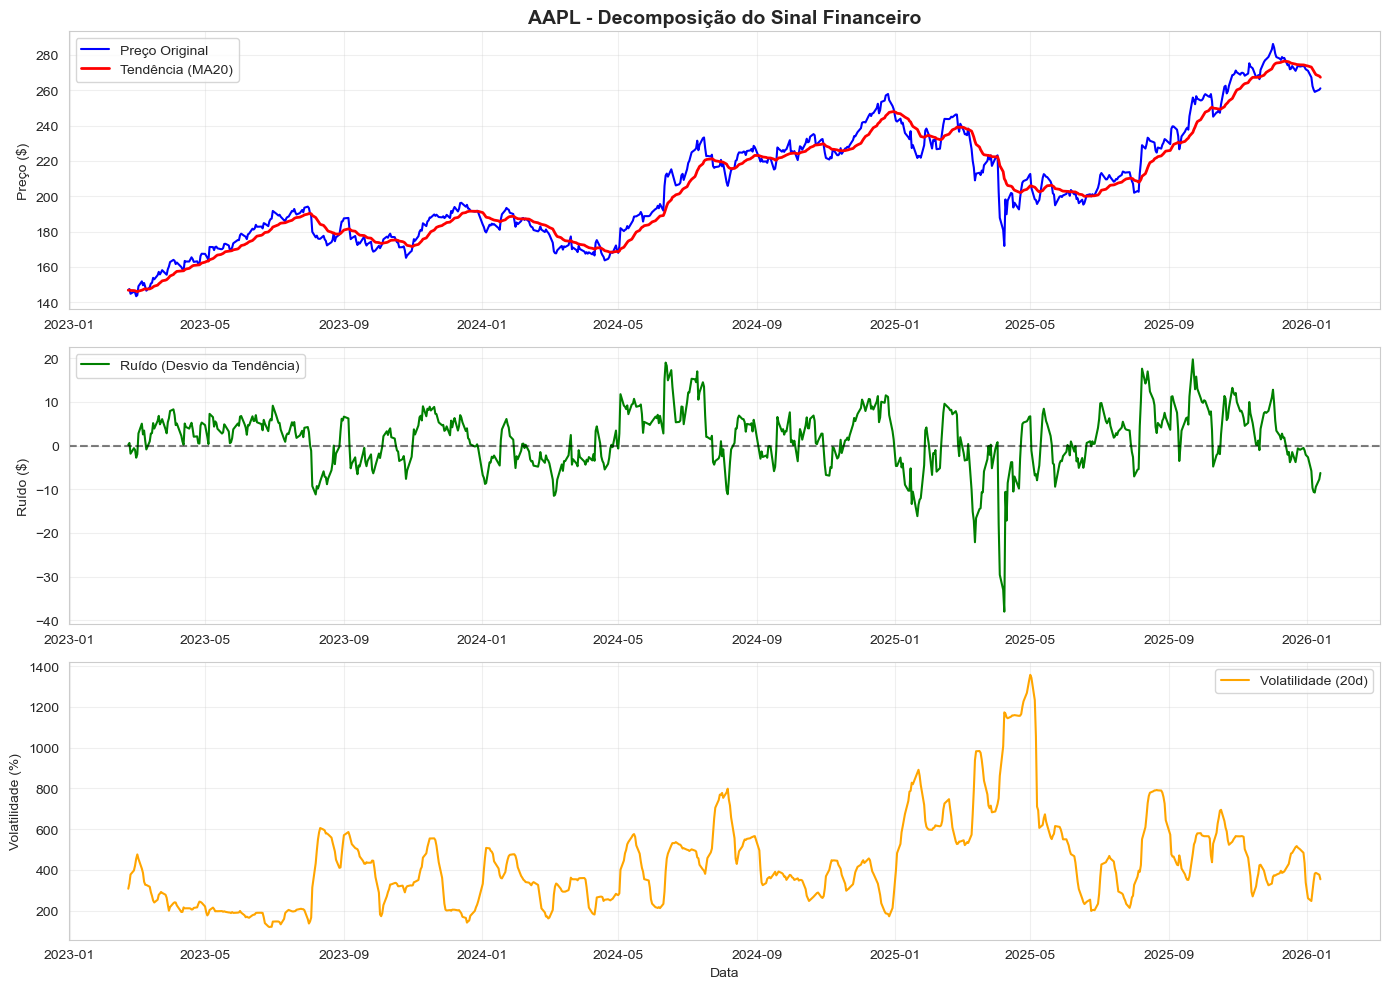

In [115]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
sample = df_clean[df_clean['Ticker'] == 'AAPL'].iloc[-726:] # Utlimos 726 dias

axes[0].plot(sample['Date'], sample['Close'], label='Preço Original', color='blue')
axes[0].plot(sample['Date'], sample['Trend'], label='Tendência (MA20)', color='red', linewidth=2)
axes[0].set_title('AAPL - Decomposição do Sinal Financeiro', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Preço ($)')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(sample['Date'], sample['Noise'], label='Ruído (Desvio da Tendência)', color='green')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Ruído ($)')
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].plot(sample['Date'], sample['Volatility']*100, label='Volatilidade (20d)', color='orange')
axes[2].set_ylabel('Volatilidade (%)')
axes[2].set_xlabel('Data')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## EDA -  Análise Exploratórica dos Dados

In [30]:
print("=" * 80)
print("Análise das estatísticas Descritivas")
print("=" * 80)

for ticker in df_clean['Ticker'].unique():
    data = df_clean[df_clean['Ticker'] == ticker]
    print(f"\n{ticker}:")
    print(f"  Preço médio: ${data['Close'].mean():.2f}")
    print(f"  Volatilidade (std): {data['Close'].std():.2f}")
    print(f"  Retorno médio diário: {data['Return_1d'].mean()*100:.4f}%")
    print(f"  Retorno total período: {((data['Close'].iloc[-1]/data['Close'].iloc[0])-1)*100:.2f}%")
    print(f"  Sharpe Ratio (aprox): {(data['Return_1d'].mean()/data['Return_1d'].std())*np.sqrt(252):.2f}")

Análise das estatísticas Descritivas

AAPL:
  Preço médio: $182.54
  Volatilidade (std): 39.67
  Retorno médio diário: 0.0796%
  Retorno total período: 122.97%
  Sharpe Ratio (aprox): 0.73

MSFT:
  Preço médio: $349.08
  Volatilidade (std): 87.85
  Retorno médio diário: 0.0729%
  Retorno total período: 107.84%
  Sharpe Ratio (aprox): 0.71

GOOGL:
  Preço médio: $149.01
  Volatilidade (std): 47.63
  Retorno médio diário: 0.1183%
  Retorno total período: 233.09%
  Sharpe Ratio (aprox): 0.96


In [32]:
print("=" * 80)
print("Análise das distribuições dos targets")
print("=" * 80)

print("\nTarget Binary (Sobe/Desce):")
print(df_clean['Target_Binary'].value_counts(normalize=True))
    
trend_dist = df_clean['Trend_Class'].value_counts().sort_index()
trend_labels = {-1: 'Lateral', 0: 'Baixa', 1:'Alta'}

for value, count in trend_dist.items():
    label = trend_labels.get(value, 'Desconhecido')
    pct = (count / len(df_clean)) * 100
    print(f"{label}: {pct:.2f}%")

Análise das distribuições dos targets

Target Binary (Sobe/Desce):
Target_Binary
1    0.531457
0    0.468543
Name: proportion, dtype: float64
Lateral: 32.67%
Baixa: 22.13%
Alta: 45.20%


In [34]:
print("=" * 80)
print("Features mais correlacionadas com o retorno futuro")
print("=" * 80)

print("Top 10 Features")

correlation_cols = [col for col in df_clean.columns if col not in 
                   ['Date', 'Ticker', 'Target_Binary', 'Target_Multiclass', 
                    'Target_Volatility', 'Future_Return', 'Future_Price', 
                    'Price_Change_Pct', 'Target_PriceRange', 'Open', 'High', 
                    'Low', 'Close', 'Volume']]
correlations = df_clean[correlation_cols + 
                ['Future_Return']].corr()['Future_Return'].abs().sort_values(ascending=False)

print(correlations.head(11)[1:])

Features mais correlacionadas com o retorno futuro
Top 10 Features
Price
BB_Dist_Upper     0.043632
Return_5d         0.041468
MACD_Diff         0.036672
Return_10d        0.035814
SMA_Cross_5_20    0.033503
Noise             0.032488
BB_Dist_Lower     0.027814
Daily_Range_MA    0.027206
Volatility_5d     0.023248
Volatility        0.019457
Name: Future_Return, dtype: float64


Salvo: 01_precos_tendencia.png


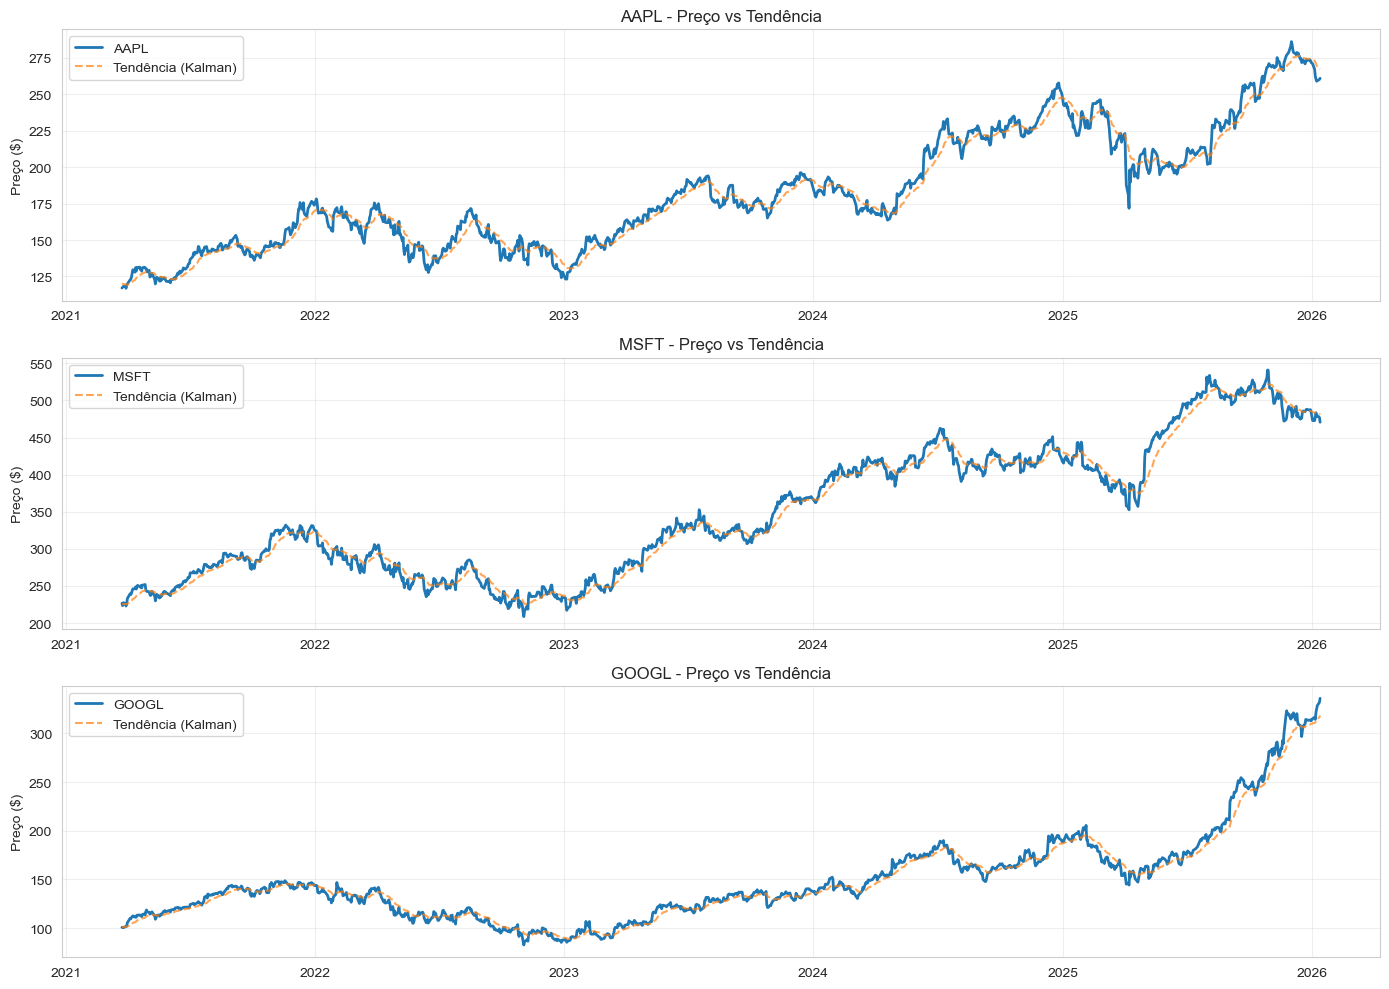

In [40]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
for idx, ticker in enumerate(df_clean['Ticker'].unique()):
    data = df_clean[df_clean['Ticker'] == ticker]
    axes[idx].plot(data['Date'], data['Close'], label=ticker, linewidth=2)
    axes[idx].plot(data['Date'], data['Trend'], label='Tendência (Kalman)', 
                  linewidth=1.5, linestyle='--', alpha=0.7)
    axes[idx].set_title(f'{ticker} - Preço vs Tendência')
    axes[idx].set_ylabel('Preço ($)')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./Images-NoteBook/EDA/01_precos_tendencia.png', dpi=300, bbox_inches='tight')
print("Salvo: 01_precos_tendencia.png")
plt.show()

Salvo: 02_correlacao_features.png


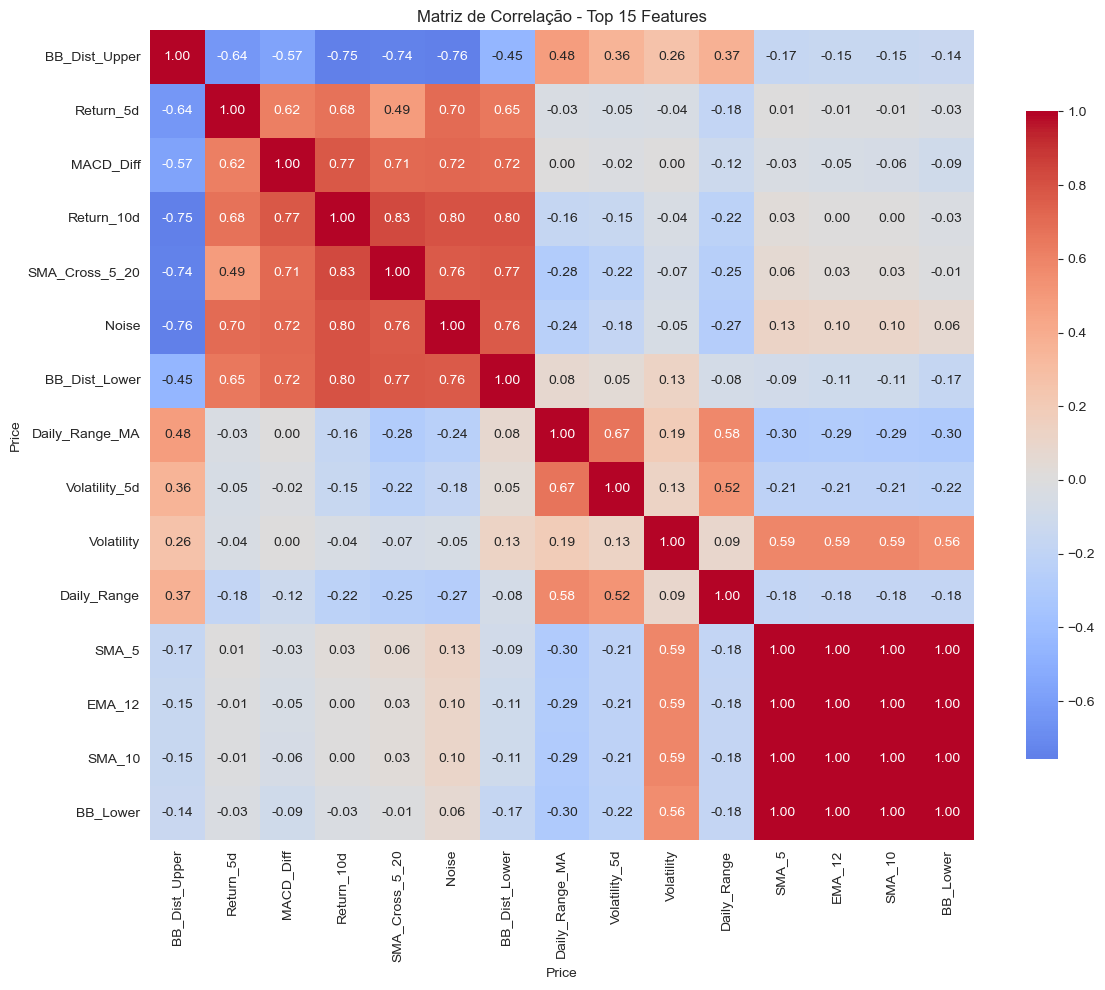

In [43]:
fig, ax = plt.subplots(figsize=(12, 10))
top_features = correlations.head(16)[1:].index.tolist()
corr_matrix = df_clean[top_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=ax, cbar_kws={'shrink': 0.8})
plt.title('Matriz de Correlação - Top 15 Features')
plt.tight_layout()
plt.savefig('./Images-NoteBook/EDA/02_correlacao_features.png', dpi=300, bbox_inches='tight')
print("Salvo: 02_correlacao_features.png")
plt.show()

Salvo: 03_distribuicao_retornos.png


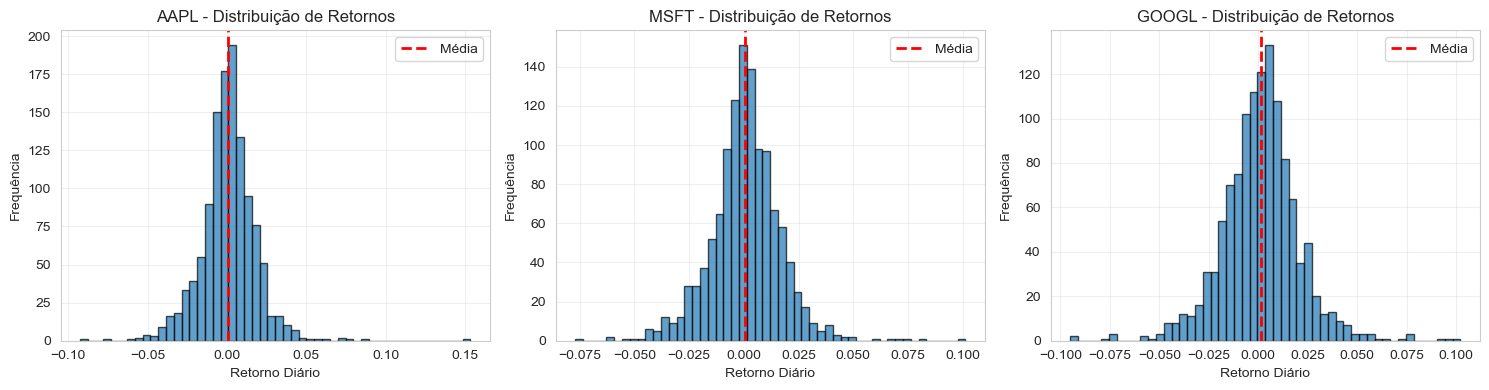

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
for idx, ticker in enumerate(df_clean['Ticker'].unique()):
    data = df_clean[df_clean['Ticker'] == ticker]
    axes[idx].hist(data['Return_1d'], bins=50, alpha=0.7, edgecolor='black')
    axes[idx].axvline(data['Return_1d'].mean(), color='red', 
                     linestyle='--', linewidth=2, label='Média')
    axes[idx].set_title(f'{ticker} - Distribuição de Retornos')
    axes[idx].set_xlabel('Retorno Diário')
    axes[idx].set_ylabel('Frequência')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./Images-NoteBook/EDA/03_distribuicao_retornos.png', dpi=300, bbox_inches='tight')
print("Salvo: 03_distribuicao_retornos.png")
plt.show()

### Divisão Temporal dos Dados

Divisão dos dados com base no split temporal: 80% para treino e 20% para teste


In [46]:
df_clean = df_clean.sort_values('Date')

split_date = df_clean['Date'].quantile(0.8)
train_mask = df_clean['Date'] <= split_date
test_mask = df_clean['Date'] > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train_binary = y_binary[train_mask]
y_test_binary = y_binary[test_mask]
y_train_multi = y_multi[train_mask]
y_test_multi = y_multi[test_mask]
y_train_vol = y_vol[train_mask]
y_test_vol = y_vol[test_mask]

print(f"Treino: {len(X_train)} amostras ({df_clean[train_mask]['Date'].min().date()} até {df_clean[train_mask]['Date'].max().date()})")
print(f"Teste: {len(X_test)} amostras ({df_clean[test_mask]['Date'].min().date()} até {df_clean[test_mask]['Date'].max().date()})")

Treino: 2901 amostras (2021-03-24 até 2025-01-28)
Teste: 723 amostras (2025-01-29 até 2026-01-13)


### Normalização 

In [49]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## ML - Treino do Modelo

In [51]:
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=2000,
        C=0.1,
        penalty="l2",
        class_weight="balanced",
        solver="lbfgs",
        random_state=42
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=500,
        max_depth=5,
        min_samples_leaf=50,
        max_features="sqrt",
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=42
    ),

    "XGBoost": XGBClassifier(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=20,
        gamma=1,
        reg_lambda=5,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42
    ),

    "LightGBM": LGBMClassifier(
        n_estimators=600,
        learning_rate=0.03,
        max_depth=4,
        num_leaves=15,
        min_child_samples=50,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=5,
        class_weight="balanced",
        verbose=-1,
        random_state=42
    )
}


results = {
    'Binary': {},
    'Multiclass': {},
    'Volatility': {}
}

In [64]:
print("n" * 80)
print("\nTARGET 1: Classificação Binária (Sobe/Desce)")
print("="*80)

for name, model in models.items():
    print(f"\nTreinando {name}...", end=" ")
    model.fit(X_train_scaled, y_train_binary)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test_binary, y_pred)
    bal_acc = balanced_accuracy_score(y_test_binary, y_pred)
    f1 = f1_score(y_test_binary, y_pred)
    auc = roc_auc_score(y_test_binary, y_pred_proba)
    
    results['Binary'][name] = {
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'f1_score': f1,
        'auc_roc': auc,
        'model': model
    }
    
    print(f"= * 80")
    print(f"  Acurácia: {acc:.4f} | Balanced Acc: {bal_acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")


print("n" * 80)
print("\nTARGET 2: Classificação Multiclasse (Alta/Neutro/Baixa)")
print("="*80)

for name, model in models.items():
    print(f"\nTreinando {name}...", end=" ")
    model_multi = type(model)(**model.get_params())  # Clone
    model_multi.fit(X_train_scaled, y_train_multi)
    y_pred = model_multi.predict(X_test_scaled)
    
    acc = accuracy_score(y_test_multi, y_pred)
    bal_acc = balanced_accuracy_score(y_test_multi, y_pred)
    f1 = f1_score(y_test_multi, y_pred, average='weighted')
    
    results['Multiclass'][name] = {
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'f1_score': f1,
        'model': model_multi
    }
    
    print(f"  Acurácia: {acc:.4f} | Balanced Acc: {bal_acc:.4f} | F1: {f1:.4f}")

print("="*80)
print("\nTARGET 3: Previsão de Volatilidade (Volátil/Estável)")
print("="*80)

for name, model in models.items():
    print(f"\nTreinando {name}...", end=" ")
    model_vol = type(model)(**model.get_params())  # Clone
    model_vol.fit(X_train_scaled, y_train_vol)
    y_pred = model_vol.predict(X_test_scaled)
    y_pred_proba = model_vol.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test_vol, y_pred)
    bal_acc = balanced_accuracy_score(y_test_vol, y_pred)
    f1 = f1_score(y_test_vol, y_pred)
    auc = roc_auc_score(y_test_vol, y_pred_proba)
    
    results['Volatility'][name] = {
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'f1_score': f1,
        'auc_roc': auc,
        'model': model_vol
    }

    print(f"  Acurácia: {acc:.4f} | Balanced Acc: {bal_acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn

TARGET 1: Classificação Binária (Sobe/Desce)

Treinando Logistic Regression... = * 80
  Acurácia: 0.5242 | Balanced Acc: 0.5265 | F1: 0.5275 | AUC: 0.5190

Treinando Random Forest... = * 80
  Acurácia: 0.5228 | Balanced Acc: 0.5314 | F1: 0.4828 | AUC: 0.5376

Treinando Gradient Boosting... = * 80
  Acurácia: 0.5048 | Balanced Acc: 0.5087 | F1: 0.4972 | AUC: 0.5151

Treinando XGBoost... = * 80
  Acurácia: 0.5090 | Balanced Acc: 0.5048 | F1: 0.5512 | AUC: 0.5054

Treinando LightGBM... = * 80
  Acurácia: 0.5076 | Balanced Acc: 0.5133 | F1: 0.4870 | AUC: 0.5229
nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn

TARGET 2: Classificação Multiclasse (Alta/Neutro/Baixa)

Treinando Logistic Regression...   Acurácia: 0.3734 | Balanced Acc: 0.3766 | F1: 0.3671

Treinando Random Forest...   Acurácia: 0.3804 | Balanced Acc: 0.3853 | F1: 0.3701

Treinando Gradient Boosting...   Acurácia: 

#### Analise de Resultados

In [65]:
comparison_data = []
for task in ['Binary', 'Multiclass', 'Volatility']:
    for model_name, metrics in results[task].items():
        comparison_data.append({
            'Tarefa': task,
            'Modelo': model_name,
            'Acurácia': metrics['accuracy'],
            'Balanced Acc': metrics['balanced_accuracy'],
            'F1-Score': metrics['f1_score'],
            'AUC-ROC': metrics.get('auc_roc', np.nan)
        })

df_results = pd.DataFrame(comparison_data)

nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn

Tabela Comparativa de Métricas:
nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn
    Tarefa              Modelo  Acurácia  Balanced Acc  F1-Score  AUC-ROC
    Binary Logistic Regression  0.524205      0.526527  0.527473 0.519011
    Binary       Random Forest  0.522822      0.531355  0.482759 0.537583
    Binary   Gradient Boosting  0.504841      0.508690  0.497191 0.515118
    Binary             XGBoost  0.508990      0.504808  0.551201 0.505362
    Binary            LightGBM  0.507607      0.513306  0.487032 0.522927
Multiclass Logistic Regression  0.373444      0.376638  0.367077      NaN
Multiclass       Random Forest  0.380360      0.385315  0.370119      NaN
Multiclass   Gradient Boosting  0.354080      0.354267  0.343921      NaN
Multiclass             XGBoost  0.374827      0.372687  0.373753      NaN
Multiclass            LightGBM  0.363762      0.366978  0.362836 

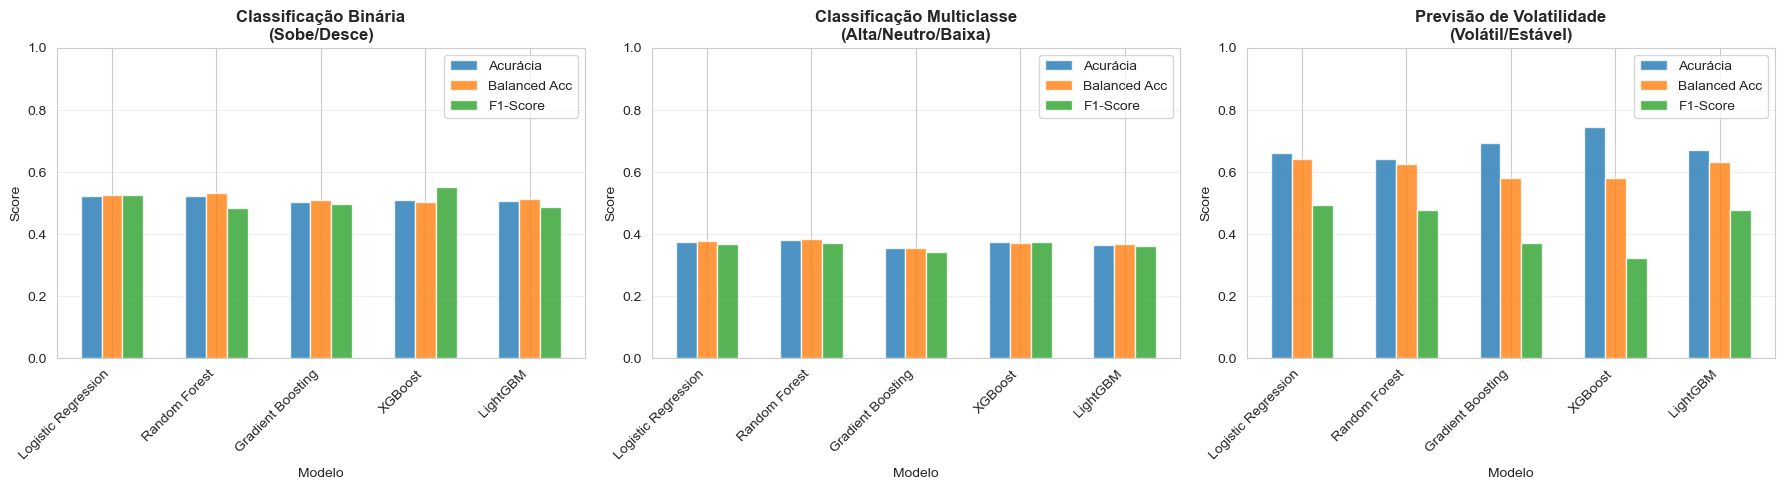

In [66]:
print("n" * 80)
print("\nTabela Comparativa de Métricas:")
print("n" * 80)

print(df_results.to_string(index=False))

# Visualização dos resultados
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

tasks = ['Binary', 'Multiclass', 'Volatility']
titles = ['Classificação Binária\n(Sobe/Desce)', 
          'Classificação Multiclasse\n(Alta/Neutro/Baixa)', 
          'Previsão de Volatilidade\n(Volátil/Estável)']

for idx, (task, title) in enumerate(zip(tasks, titles)):
    data = df_results[df_results['Tarefa'] == task]
    
    x = np.arange(len(data))
    width = 0.2
    
    axes[idx].bar(x - width, data['Acurácia'], width, label='Acurácia', alpha=0.8)
    axes[idx].bar(x, data['Balanced Acc'], width, label='Balanced Acc', alpha=0.8)
    axes[idx].bar(x + width, data['F1-Score'], width, label='F1-Score', alpha=0.8)
    
    axes[idx].set_xlabel('Modelo')
    axes[idx].set_ylabel('Score')
    axes[idx].set_title(title, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(data['Modelo'], rotation=45, ha='right')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim(0, 1)

plt.tight_layout()
plt.savefig("./Images-NoteBook/ML/04_Comparative_Metrics_Table.png", dpi=300, bbox_inches='tight')
plt.show()

### Análise em detalhe do melhor modelo

Análise detalhada do melhor modelo

 Melhor modelo: Random Forest
   Balanced Accuracy: 0.5314


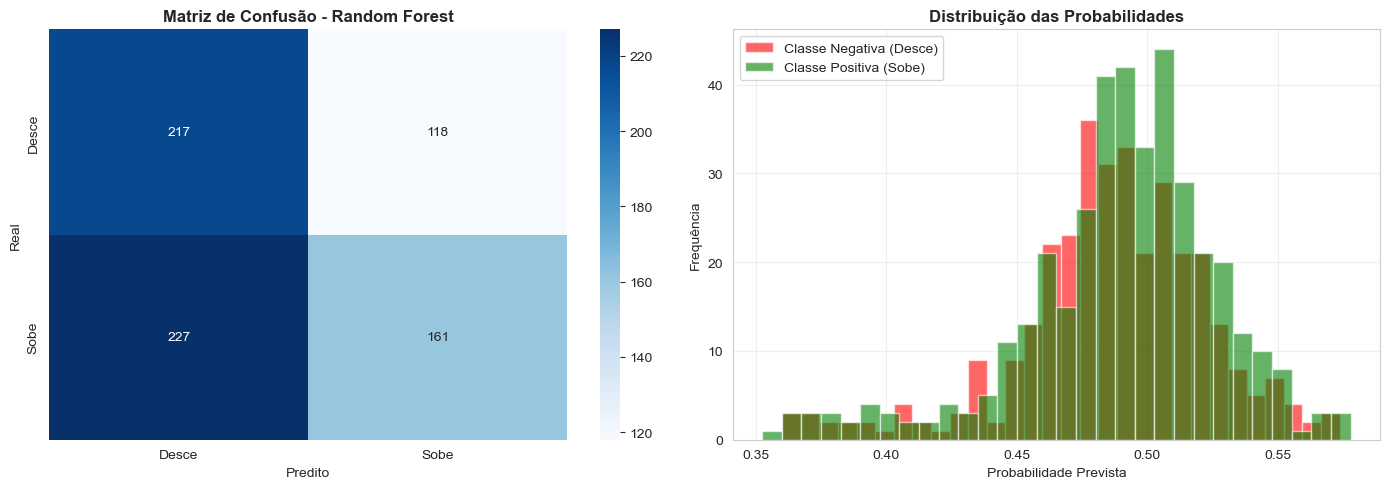

In [67]:
print("=" * 80)
print("Análise detalhada do melhor modelo")
print("=" * 80)

# Selecionar melhor modelo para classificação binária
best_model_name = max(results['Binary'], key=lambda x: results['Binary'][x]['balanced_accuracy'])
best_model = results['Binary'][best_model_name]['model']

print(f"\n Melhor modelo: {best_model_name}")
print(f"   Balanced Accuracy: {results['Binary'][best_model_name]['balanced_accuracy']:.4f}")

# Predições
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Matriz de confusão
cm = confusion_matrix(y_test_binary, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de confusão
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'Matriz de Confusão - {best_model_name}', fontweight='bold')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predito')
axes[0].set_xticklabels(['Desce', 'Sobe'])
axes[0].set_yticklabels(['Desce', 'Sobe'])

# Distribuição de probabilidades
axes[1].hist(y_pred_proba[y_test_binary == 0], bins=30, alpha=0.6, label='Classe Negativa (Desce)', color='red')
axes[1].hist(y_pred_proba[y_test_binary == 1], bins=30, alpha=0.6, label='Classe Positiva (Sobe)', color='green')
axes[1].set_xlabel('Probabilidade Prevista')
axes[1].set_ylabel('Frequência')
axes[1].set_title('Distribuição das Probabilidades', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("./Images-NoteBook/ML/05_Best_Model_Analys.png", dpi=300, bbox_inches='tight')
plt.show()

### Overview da Classificação


Relatório de Classificação:
              precision    recall  f1-score   support

       Desce       0.49      0.65      0.56       335
        Sobe       0.58      0.41      0.48       388

    accuracy                           0.52       723
   macro avg       0.53      0.53      0.52       723
weighted avg       0.54      0.52      0.52       723


Top 10 Features Mais Importantes:
        Feature  Importance
     Return_10d    0.086858
      Return_1d    0.085926
 SMA_Cross_5_20    0.068609
          Noise    0.063795
SMA_Cross_10_50    0.062718
      Return_5d    0.062258
   Volume_Ratio    0.061644
  Volatility_5d    0.061394
     Volatility    0.057245
         RSI_14    0.053311


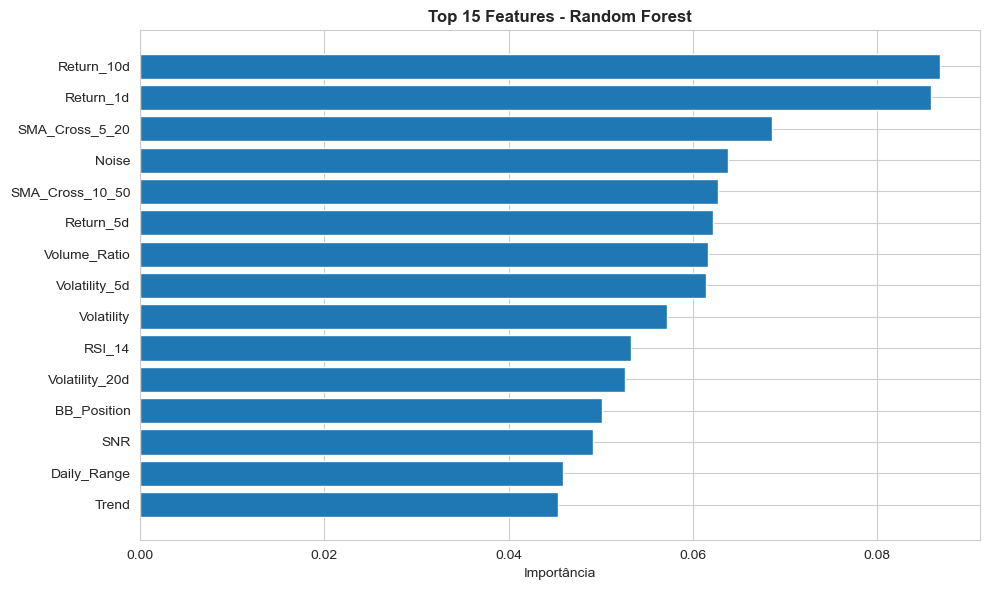

In [68]:
print("=" * 80)
print("\nRelatório de Classificação:")
print("=" * 80)
print(classification_report(y_test_binary, y_pred, target_names=['Desce', 'Sobe']))

# Feature importance (se disponível)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 10 Features Mais Importantes:")
    print(feature_importance.head(10).to_string(index=False))
    
    # Visualizar
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'].head(15), feature_importance['Importance'].head(15))
    plt.xlabel('Importância')
    plt.title(f'Top 15 Features - {best_model_name}', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig("./Images-NoteBook/ML/06_Feature_Importance.png", dpi=300, bbox_inches='tight')
    plt.show()

## INFERÊNCIA EM DADOS ATUAIS DO MERCADO

In [69]:
latest_data = df_clean.groupby('Ticker').tail(1)
X_latest = latest_data[feature_cols]
X_latest_scaled = scaler.transform(X_latest)

# Predições
pred_binary = best_model.predict(X_latest_scaled)
pred_proba = best_model.predict_proba(X_latest_scaled)[:, 1]

# Criar DataFrame de resultados
inference_results = pd.DataFrame({
    'Ticker': latest_data['Ticker'].values,
    'Data': latest_data['Date'].values,
    'Preço Atual': latest_data['Close'].values,
    'Previsão': ['SOBE' if p == 1 else 'DESCE ↓' for p in pred_binary],
    'Confiança (%)': pred_proba * 100,
    'Sinal': ['FORTE' if (p > 0.6 or p < 0.4) else 'FRACO' for p in pred_proba]
})

print("Previsões para o Próximo Dia:")
print("\n")
print(inference_results.to_string(index=False))

# Tendência agregada do mercado
market_sentiment = pred_binary.mean()
print(f"\nTENDÊNCIA AGREGADA DO MERCADO:")
if market_sentiment > 0.6:
    print(f"    ALTA ({market_sentiment*100:.1f}% das ações com tendência de subida)")
elif market_sentiment < 0.4:
    print(f"    BAIXA ({(1-market_sentiment)*100:.1f}% das ações com tendência de queda)")
else:
    print(f"    NEUTRA ({market_sentiment*100:.1f}% de equilíbrio)")

Previsões para o Próximo Dia:


Ticker       Data  Preço Atual Previsão  Confiança (%) Sinal
  MSFT 2026-01-13   470.670013     SOBE      50.781716 FRACO
  AAPL 2026-01-13   261.049988     SOBE      51.903808 FRACO
 GOOGL 2026-01-13   335.970001  DESCE ↓      45.970744 FRACO

TENDÊNCIA AGREGADA DO MERCADO:
    ALTA (66.7% das ações com tendência de subida)


Apesar de a maioria das ações analisadas apresentar probabilidade ligeiramente superior a 50% de movimento positivo, todas as previsões individuais exibem baixa confiança. Assim, a tendência agregada deve ser interpretada como um viés marginal de subida, e não como uma indicação robusta de tendência de mercado

**Comentário sobre os resultados**

> Os resultados obtidos evidenciam a elevada dificuldade inerente à previsão direcional de curto prazo, sendo o desempenho marginalmente superior ao acaso consistente com mercados altamente eficientes.

## Exportação do Modelo

In [73]:
best_model_name = max(results['Binary'], key=lambda x: results['Binary'][x]['balanced_accuracy'])
best_model = results['Binary'][best_model_name]['model']
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = "./Models"

In [79]:
print("="*80)
print("EXPORTAÇÃO DO MODELO")
print("="*80)

#Guardar o melhor modelo - Random Forest
model_filename = f'{model_dir}/rf_binary_classifier_{timestamp}.pkl'
joblib.dump(best_model, model_filename)
print(f"\nModelo guardado: {model_filename}")

# Guardar o Scaler
scaler_filename = f'{model_dir}/scaler_{timestamp}.pkl'
joblib.dump(scaler, scaler_filename)
print(f"Scaler guardado: {scaler_filename}")

#Guardar Metadados
model_metadata = {
    'model_type': best_model_name,
    'model_class': str(type(best_model).__name__),
    'features': feature_cols,
    'n_features': len(feature_cols),
    'target': 'Target_Binary',
    'target_description': 'Classificação binária: 1=Sobe, 0=Desce',
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'metrics': {
        'accuracy': float(results['Binary'][best_model_name]['accuracy']),
        'balanced_accuracy': float(results['Binary'][best_model_name]['balanced_accuracy']),
        'f1_score': float(results['Binary'][best_model_name]['f1_score']),
        'auc_roc': float(results['Binary'][best_model_name]['auc_roc'])
    },
    'training_period': {
        'start': str(df_clean[train_mask]['Date'].min().date()),
        'end': str(df_clean[train_mask]['Date'].max().date())
    },
    'test_period': {
        'start': str(df_clean[test_mask]['Date'].min().date()),
        'end': str(df_clean[test_mask]['Date'].max().date())
    },
    'stocks': tickers,
    'data_split': '80% treino / 20% teste (temporal)',
    'timestamp': timestamp,
    'export_date': str(datetime.now())
}

metadata_filename = f'{model_dir}/model_metadata_{timestamp}.json'
with open(metadata_filename, 'w', encoding='utf-8') as f:
    json.dump(model_metadata, f, indent=4, ensure_ascii=False)
print(f"Metadados guardados: {metadata_filename}")

EXPORTAÇÃO DO MODELO

Modelo guardado: ./Models/rf_binary_classifier_20260114_225303.pkl
Scaler guardado: ./Models/scaler_20260114_225303.pkl
Metadados guardados: ./Models/model_metadata_20260114_225303.json


#### Criar arquivo de instruções de uso

In [95]:
instructions = f"""
# Instruções de Uso do Modelo

## Arquivos gerados:
1. {model_filename} - Modelo Random Forest treinado
2. {scaler_filename} - Scaler para normalização
3. {metadata_filename} - Metadados e configuração

## Como carregar o modelo:
```python
import joblib
import pandas as pd

# Carregar modelo e scaler
model = joblib.load('{model_filename}')
scaler = joblib.load('{scaler_filename}')

# Features necessárias (na ordem correta):
features = {feature_cols}

# Fazer previsão com novos dados:
# 1. Preparar DataFrame com as features
# X_new = pd.DataFrame(...)  # seus novos dados

# 2. Normalizar
# X_new_scaled = scaler.transform(X_new[features])

# 3. Prever
# predictions = model.predict(X_new_scaled)
# probabilities = model.predict_proba(X_new_scaled)[:, 1]
```

## Métricas do Modelo:
- Balanced Accuracy: {results['Binary'][best_model_name]['balanced_accuracy']:.4f}
- F1-Score: {results['Binary'][best_model_name]['f1_score']:.4f}
- AUC-ROC: {results['Binary'][best_model_name]['auc_roc']:.4f}

## Período de Treino: {df_clean[train_mask]['Date'].min().date()} a {df_clean[train_mask]['Date'].max().date()}
## Período de Teste: {df_clean[test_mask]['Date'].min().date()} a {df_clean[test_mask]['Date'].max().date()}
"""

instructions_filename = f'{model_dir}/INSTRUCTIONS_{timestamp}.txt'
with open(instructions_filename, 'w', encoding='utf-8') as f:
    f.write(instructions)
print(f"Instruções salvas: {instructions_filename}")

print(f"{'='*80}")
print(f"\nTodos os arquivos foram guardados na pasta: {model_dir}/")
print(f"\nPara usar o modelo posteriormente:")
print(f"  model = joblib.load('{model_filename}')")
print(f"  scaler = joblib.load('{scaler_filename}')")

Instruções salvas: ./Models/INSTRUCTIONS_20260114_225303.txt

Todos os arquivos foram guardados na pasta: ./Models/

Para usar o modelo posteriormente:
  model = joblib.load('./Models/rf_binary_classifier_20260114_225303.pkl')
  scaler = joblib.load('./Models/scaler_20260114_225303.pkl')


#### Uso do Modelo

In [97]:
MODEL_PATH = "./Models/rf_binary_classifier_20260114_225303.pkl"  
SCALER_PATH = "./Models/scaler_20260114_225303.pkl"
METADATA_PATH = "./Models/model_metadata_20260114_225303.json"

In [99]:
model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

with open(METADATA_PATH, "r") as f:
    metadata = json.load(f)

features = metadata["features"] 

In [101]:
# Criar DataFrame de novos dados
X_new = pd.DataFrame([{feat: 0 for feat in features}])

# Valores Exemplo
X_new.loc[0, "Return_1d"] = 0.012
X_new.loc[0, "Return_5d"] = 0.045
X_new.loc[0, "Return_10d"] = 0.078
X_new.loc[0, "SMA_Cross_5_20"] = 1
X_new.loc[0, "SMA_Cross_10_50"] = 0
X_new.loc[0, "RSI_14"] = 58.3
X_new.loc[0, "BB_Position"] = 0.62
X_new.loc[0, "MACD_Diff"] = 0.13
X_new.loc[0, "Volume_Ratio"] = 1.2
X_new.loc[0, "Volatility_5d"] = 0.012
X_new.loc[0, "Volatility_20d"] = 0.015
X_new.loc[0, "Daily_Range"] = 3.2
X_new.loc[0, "Daily_Range_MA"] = 2.1
X_new.loc[0, "Trend"] = 1
X_new.loc[0, "Noise"] = 0.003
X_new.loc[0, "Volatility"] = 0.012

In [93]:
X_scaled = scaler.transform(X_new[features])

pred = model.predict(X_scaled)[0]
prob = model.predict_proba(X_scaled)[0, 1]  # probabilidade da classe 1 (subida)

print("Predição (0=Desce, 1=Sobe):", pred)
print(f"Probabilidade de subida: {prob:.2%}")

Predição (0=Desce, 1=Sobe): 1
Probabilidade de subida: 53.92%
